In [11]:
# Display tools
from IPython.display import HTML, display  # For HTML rendering in notebooks
import os 
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
import os

def get_dicom_paths(directory_path, label=None, verbose=True):
    """
    Scans a directory for DICOM (.dcm) files and returns their paths.

    Parameters:
    - directory_path (str): Directory to scan for .dcm files
    - label (str, optional): Label for display (e.g., 'train', 'test')
    - verbose (bool): Whether to print the number of files found

    Returns:
    - List[str]: Paths to DICOM files
    """
    dicom_paths = [
        os.path.join(directory_path, file)
        for file in os.listdir(directory_path)
        if file.lower().endswith('.dcm')
    ]
    
    if verbose:
        label_text = f" in the '{label}' directory" if label else ""
        print(f" Found {len(dicom_paths)} DICOM files{label_text}.")
    
    return dicom_paths

# --- Define Image Directories ---
TRAIN_IMG_DIR = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_images"
TEST_IMG_DIR  = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_test_images"

# --- Get File Paths ---
train_img_path = get_dicom_paths(TRAIN_IMG_DIR, label="train")
test_img_path  = get_dicom_paths(TEST_IMG_DIR, label="test")


 Found 26684 DICOM files in the 'train' directory.
 Found 3000 DICOM files in the 'test' directory.


In [13]:
labels = pd.read_csv(r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_labels.csv")
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [14]:
count_normal = len(labels.loc[labels['Target']==0])
count_pnemonia= len(labels.loc[labels['Target']==1])
traing_count=len(train_img_path)

In [15]:
weight_for_zero =(1/count_normal)*(traing_count)/2.0
weight_for_ones =(1/count_pnemonia)*(traing_count)/2.0

In [16]:
classweight= {0: weight_for_zero,
              1: weight_for_ones}

In [17]:
print("Weights:", classweight)

Weights: {0: 0.6454140866873065, 1: 1.3963369963369963}


In [18]:
def parseMetadata(dcm):  # corrected from 'paraseMetadata'
    unpackedData = {}
    groupElemToKeywords = {}
    
    for d in dcm:  # This forces conversion from lazy RawDataElement to DataElement
        pass

    # Un-pack Data
    for tag, elem in dcm.items():
        tagGroup = tag.group
        tagElem = tag.elem
        keyword = elem.keyword
        groupElemToKeywords[(tagGroup, tagElem)] = keyword
        value = elem.value
        unpackedData[keyword] = value
        
    return unpackedData, groupElemToKeywords


In [19]:
import pydicom
from tqdm import tqdm

In [20]:


# Step 1: Read DICOM files from paths
train_dcms = [pydicom.dcmread(path) for path in tqdm(train_img_path[:5000])]
test_dcms = [pydicom.dcmread(path) for path in tqdm(test_img_path[:5000])]




100%|██████████| 3000/3000 [00:38<00:00, 78.53it/s]


In [21]:
# Step 2: Parse metadata from DICOM datasets
trainMetaDicts, trainKeyword = zip(*[parseMetadata(dcm) for dcm in tqdm(train_dcms)])
testMetaDicts, testKeyword = zip(*[parseMetadata(dcm) for dcm in tqdm(test_dcms)])

100%|██████████| 3000/3000 [00:02<00:00, 1297.18it/s]


In [22]:
def createY(df):
    """
    Returns binary labels: 1 if 'SeriesDescription' is 'view: PA', else 0.
    """
    if 'SeriesDescription' not in df.columns:
        raise ValueError("Missing 'SeriesDescription' column in DataFrame.")
    
    return (df['SeriesDescription'] == 'view: PA').astype(int).values


In [23]:
train_df = pd.DataFrame.from_dict(data=trainMetaDicts)
test_df = pd.DataFrame.from_dict(data=testMetaDicts)

train_df['dataset'] = 'train'
test_df['dataset'] = 'test'

train_Y = createY(train_df)
test_Y = createY(test_df)


In [24]:
test_Y

array([1, 1, 1, ..., 1, 1, 1])

In [25]:
def decodeImage(filePath):
    image = pydicom.dcmread(filePath).pixel_array
    image = cv2.resize(image, (64, 64))
    return image / 255.0


In [26]:

import cv2
import numpy as np

# Get our train x in the correct shape
train_X = []

for filePath in tqdm(train_img_path[:5000]):
    
    img = decodeImage(filePath)
    train_X.append(img)

train_X = np.array(train_X) # Convert to np.array
train_X_rgb = np.repeat(train_X[..., np.newaxis], 3, -1) # Reshape into rgb format

100%|██████████| 5000/5000 [00:35<00:00, 140.22it/s]


In [27]:
train_X_rgb

array([[[[0.01176471, 0.01176471, 0.01176471],
         [0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.        , 0.        , 0.        ],
         [0.0745098 , 0.0745098 , 0.0745098 ]],

        [[0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.        , 0.        , 0.        ],
         [0.00392157, 0.00392157, 0.00392157]],

        ...,

        [[0.01176471, 0.01176471, 0.01176471],
         [0.00784314, 0.00784314, 0.00784314]

In [28]:
test_X =[]
for filePath in tqdm(test_img_path[:5000]):
    
    img = decodeImage(filePath)
    test_X.append(img)

test_X = np.array(test_X) # Convert to np array
test_X_rgb = np.repeat(test_X[..., np.newaxis], 3, -1) # Reshape into rgb format

100%|██████████| 3000/3000 [00:22<00:00, 135.74it/s]


In [29]:
import matplotlib.pyplot as plt

def plot_score(hist):
    fig, ax = plt.subplots(5, 1, figsize=(10, 20))  # Corrected 'subplot' to 'subplots'
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'precision', 'recall', 'AUC', 'loss']):
        ax[i].plot(hist.history[met])
        ax[i].plot(hist.history['val_' + met])
        ax[i].set_title(f'Model {met}')
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()


In [30]:
!pip install tensorflow 

In [31]:
import tensorflow as tf

In [32]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Model


In [33]:
# These our our scoring metrics that are going to be used to evaluate our models
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'), 
           tf.keras.metrics.AUC(name='AUC')]

In [34]:
import tensorflow as tf

# Clear, Flexible Exponential Decay Function
def exponential_decay(lr_initial, decay_steps, decay_rate=0.1):
    """
    Returns a function that computes exponentially decaying learning rate.
    
    Parameters:
    - lr_initial: Initial learning rate
    - decay_steps: Controls the rate of decay
    - decay_rate: The base of the exponential decay (default: 0.1)

    Returns:
    - A function that takes an epoch index and returns the decayed learning rate
    """
    def schedule(epoch):
        return lr_initial * decay_rate ** (epoch / decay_steps)
    return schedule

# Define the scheduler function
exponential_decay_fn = exponential_decay(lr_initial=0.01, decay_steps=20)

# Learning Rate Scheduler Callback
lr_scheduler_cb = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn, verbose=1)

# Model Checkpoint Callback (saves best model only)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="xray_model.h5",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

# Early Stopping Callback (restores best weights after patience period)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)


In [35]:
'''
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)


'''

'\ndef exponential_decay(lr0, s):\n    def exponential_decay_fn(epoch):\n        return lr0 * 0.1 **(epoch / s)\n    return exponential_decay_fn\n\nexponential_decay_fn = exponential_decay(0.01, 20)\n\nlr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)\n\ncheckpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)\n\nearly_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)\n\n\n'

Baseline Model CNN

In [36]:
import tensorflow as tf

def build_fcnn_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(64, 64, 3)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


In [37]:
model_fcnn=build_fcnn_model()


c:\Users\samya\PyCharmProject\Pneumonia-Detection\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [38]:
model_fcnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,572,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,573,121 (6.00 MB)

 Trainable params: 1,573,121 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model_fcnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)

In [40]:
train_X_rgb = np.repeat(train_X[..., np.newaxis], 3, -1) # Reshape into rgb format
history_fcnn = model_fcnn.fit(train_X_rgb, 
                          train_Y,  
                          epochs = 100,
                          batch_size = 128,
                          validation_split = 0.15, 
                          class_weight = classweight, 
                          verbose = 1,
                          callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler_cb]) # Fit the model


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - AUC: 0.5382 - accuracy: 0.5364 - loss: 20.1007 - precision: 0.5613 - recall: 0.6286
Epoch 1: val_loss improved from inf to 0.77138, saving model to xray_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - AUC: 0.5393 - accuracy: 0.5373 - loss: 19.4906 - precision: 0.5618 - recall: 0.6337 - val_AUC: 0.8598 - val_accuracy: 0.6280 - val_loss: 0.7714 - val_precision: 0.9922 - val_recall: 0.3153 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.008912509381337455.
Epoch 2/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 0.7876 - accuracy: 0.6743 - loss: 0.6109 - precision: 0.6983 - recall: 0.7559
Epoch 2: val_loss improved from 0.77138 to 0.54858, saving model to xray_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - AUC: 0.7894 - accuracy: 0.6761 - loss: 0.6041 - precision: 0.6972 - recall: 0.7625 - val_AUC: 0.9234 - val_accuracy: 0.6773 - val_loss: 0.5486 - val_precision: 0.6281 - val_recall: 0.9901 - learning_rate: 0.0089

Epoch 3: LearningRateScheduler setting learning rate to 0.007943282347242816.
Epoch 3/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - AUC: 0.9192 - accuracy: 0.7880 - loss: 0.3603 - precision: 0.7366 - recall: 0.9499
Epoch 3: val_loss improved from 0.54858 to 0.35805, saving model to xray_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - AUC: 0.9192 - accuracy: 0.7886 - loss: 0.3599 - precision: 0.7373 - recall: 0.9499 - val_AUC: 0.9287 - val_accuracy: 0.8507 - val_loss: 0.3581 - val_precision: 0.8252 - val_recall: 0.9187 - learning_rate: 0.0079

Epoch 4: LearningRateScheduler setting learning rate to 0.0070794578438413795.
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - AUC: 0.9293 - accuracy: 0.8315 - loss: 0.3226 - precision: 0.7970 - recall: 0.9285
Epoch 4: val_loss improved from 0.35805 to 0.33268, saving model to xray_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - AUC: 0.9293 - accuracy: 0.8314 - loss: 0.3225 - precision: 0.7967 - recall: 0.9288 - val_AUC: 0.9403 - val_accuracy: 0.8587 - val_loss: 0.3327 - val_precision: 0.8275 - val_recall: 0.9335 - learning_rate: 0.0071

Epoch 5: LearningRateScheduler setting learning rate to 0.006309573444801933.
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.9415 - accuracy: 0.8522 - loss: 0.2976 - precision: 0.8225 - recall: 0.9272
Epoch 5: val_loss did not improve from 0.33268
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - AUC: 0.9415 - accuracy: 0.8520 - loss: 0.2976 - precision: 0.8221 - recall: 0.9275 - val_AUC: 0.9502 - val_accuracy: 0.8253 - val_loss: 0.3768 - val_precision: 0.7680 - val_recall: 0.9704 - learning_rate: 0.0063

Epoch 6: LearningRateScheduler setting learning rate to 0.005623413251903491.
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - AUC: 0.9419 - accuracy: 0.8443 - loss: 0.2904 - precision: 0.8085 - recall: 0.9441
Epoch 6: val_

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - AUC: 0.9517 - accuracy: 0.8643 - loss: 0.2701 - precision: 0.8263 - recall: 0.9497 - val_AUC: 0.9566 - val_accuracy: 0.8693 - val_loss: 0.2953 - val_precision: 0.8348 - val_recall: 0.9458 - learning_rate: 0.0050

Epoch 8: LearningRateScheduler setting learning rate to 0.004466835921509631.
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - AUC: 0.9537 - accuracy: 0.8692 - loss: 0.2635 - precision: 0.8379 - recall: 0.9393
Epoch 8: val_loss did not improve from 0.29532
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - AUC: 0.9537 - accuracy: 0.8692 - loss: 0.2634 - precision: 0.8380 - recall: 0.9394 - val_AUC: 0.9591 - val_accuracy: 0.8613 - val_loss: 0.3306 - val_precision: 0.8094 - val_recall: 0.9729 - learning_rate: 0.0045

Epoch 9: LearningRateScheduler setting learning rate to 0.0039810717055349725.
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - AUC: 0.9534 - accuracy: 0.8639 - loss: 0.2647 - precision: 0.8263 - recall: 0.9490
Epoch 9: va

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - AUC: 0.9534 - accuracy: 0.8642 - loss: 0.2644 - precision: 0.8268 - recall: 0.9488 - val_AUC: 0.9598 - val_accuracy: 0.8800 - val_loss: 0.2696 - val_precision: 0.8591 - val_recall: 0.9310 - learning_rate: 0.0040

Epoch 10: LearningRateScheduler setting learning rate to 0.003548133892335755.
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.9589 - accuracy: 0.8751 - loss: 0.2475 - precision: 0.8496 - recall: 0.9422
Epoch 10: val_loss did not improve from 0.26961
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - AUC: 0.9589 - accuracy: 0.8751 - loss: 0.2475 - precision: 0.8496 - recall: 0.9421 - val_AUC: 0.9626 - val_accuracy: 0.8747 - val_loss: 0.2950 - val_precision: 0.8305 - val_recall: 0.9655 - learning_rate: 0.0035

Epoch 11: LearningRateScheduler setting learning rate to 0.0031622776601683794.
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - AUC: 0.9605 - accuracy: 0.8714 - loss: 0.2430 - precision: 0.8383 - recall: 0.9485
Epoch 1

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - AUC: 0.9605 - accuracy: 0.8715 - loss: 0.2432 - precision: 0.8384 - recall: 0.9484 - val_AUC: 0.9619 - val_accuracy: 0.8880 - val_loss: 0.2541 - val_precision: 0.8985 - val_recall: 0.8941 - learning_rate: 0.0032

Epoch 12: LearningRateScheduler setting learning rate to 0.002818382931264454.
Epoch 12/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 0.9578 - accuracy: 0.8806 - loss: 0.2519 - precision: 0.8581 - recall: 0.9286
Epoch 12: val_loss did not improve from 0.25411
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 0.9580 - accuracy: 0.8807 - loss: 0.2512 - precision: 0.8579 - recall: 0.9295 - val_AUC: 0.9641 - val_accuracy: 0.8880 - val_loss: 0.2581 - val_precision: 0.8693 - val_recall: 0.9335 - learning_rate: 0.0028

Epoch 13: LearningRateScheduler setting learning rate to 0.0025118864315095803.
Epoch 13/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 0.9648 - accuracy: 0.8889 - loss: 0.2308 - precision: 0.8594 - recall: 0.9482
Epoch 1

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 0.9622 - accuracy: 0.8726 - loss: 0.2416 - precision: 0.8392 - recall: 0.9563 - val_AUC: 0.9671 - val_accuracy: 0.8987 - val_loss: 0.2458 - val_precision: 0.8802 - val_recall: 0.9409 - learning_rate: 0.0018

Epoch 17: LearningRateScheduler setting learning rate to 0.0015848931924611134.
Epoch 17/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - AUC: 0.9635 - accuracy: 0.9003 - loss: 0.2331 - precision: 0.8824 - recall: 0.9378
Epoch 17: val_loss improved from 0.24583 to 0.24235, saving model to xray_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 0.9635 - accuracy: 0.8997 - loss: 0.2328 - precision: 0.8814 - recall: 0.9383 - val_AUC: 0.9675 - val_accuracy: 0.8987 - val_loss: 0.2423 - val_precision: 0.8837 - val_recall: 0.9360 - learning_rate: 0.0016

Epoch 18: LearningRateScheduler setting learning rate to 0.0014125375446227546.
Epoch 18/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - AUC: 0.9690 - accuracy: 0.8968 - loss: 0.2158 - precision: 0.8775 - recall: 0.9459
Epoch 18: val_loss improved from 0.24235 to 0.24054, saving model to xray_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - AUC: 0.9689 - accuracy: 0.8967 - loss: 0.2161 - precision: 0.8771 - recall: 0.9459 - val_AUC: 0.9679 - val_accuracy: 0.9013 - val_loss: 0.2405 - val_precision: 0.8843 - val_recall: 0.9409 - learning_rate: 0.0014

Epoch 19: LearningRateScheduler setting learning rate to 0.0012589254117941673.
Epoch 19/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - AUC: 0.9656 - accuracy: 0.8916 - loss: 0.2246 - precision: 0.8698 - recall: 0.9384
Epoch 19: val_loss did not improve from 0.24054
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - AUC: 0.9657 - accuracy: 0.8919 - loss: 0.2242 - precision: 0.8700 - recall: 0.9390 - val_AUC: 0.9687 - val_accuracy: 0.9000 - val_loss: 0.2438 - val_precision: 0.8787 - val_recall: 0.9458 - learning_rate: 0.0013

Epoch 20: LearningRateScheduler setting learning rate to 0.0011220184543019637.
Epoch 20/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - AUC: 0.9677 - accuracy: 0.8983 - loss: 0.2182 - precision: 0.8732 - recall: 0.9522
Epoch 

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - AUC: 0.9677 - accuracy: 0.8981 - loss: 0.2182 - precision: 0.8729 - recall: 0.9522 - val_AUC: 0.9684 - val_accuracy: 0.9067 - val_loss: 0.2356 - val_precision: 0.9000 - val_recall: 0.9310 - learning_rate: 0.0011

Epoch 21: LearningRateScheduler setting learning rate to 0.001.
Epoch 21/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - AUC: 0.9718 - accuracy: 0.9059 - loss: 0.2069 - precision: 0.8865 - recall: 0.9436
Epoch 21: val_loss did not improve from 0.23557
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - AUC: 0.9716 - accuracy: 0.9055 - loss: 0.2074 - precision: 0.8860 - recall: 0.9436 - val_AUC: 0.9704 - val_accuracy: 0.8720 - val_loss: 0.2858 - val_precision: 0.8229 - val_recall: 0.9729 - learning_rate: 0.0010

Epoch 22: LearningRateScheduler setting learning rate to 0.0008912509381337455.
Epoch 22/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - AUC: 0.9631 - accuracy: 0.8788 - loss: 0.2319 - precision: 0.8480 - recall: 0.9570
Epoch 22: val_loss imp

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - AUC: 0.9634 - accuracy: 0.8797 - loss: 0.2309 - precision: 0.8490 - recall: 0.9568 - val_AUC: 0.9688 - val_accuracy: 0.9053 - val_loss: 0.2309 - val_precision: 0.9095 - val_recall: 0.9163 - learning_rate: 8.9125e-04

Epoch 23: LearningRateScheduler setting learning rate to 0.0007943282347242814.
Epoch 23/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - AUC: 0.9714 - accuracy: 0.9029 - loss: 0.2064 - precision: 0.8805 - recall: 0.9553
Epoch 23: val_loss improved from 0.23091 to 0.23016, saving model to xray_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - AUC: 0.9714 - accuracy: 0.9027 - loss: 0.2066 - precision: 0.8801 - recall: 0.9552 - val_AUC: 0.9693 - val_accuracy: 0.9107 - val_loss: 0.2302 - val_precision: 0.9084 - val_recall: 0.9286 - learning_rate: 7.9433e-04

Epoch 24: LearningRateScheduler setting learning rate to 0.0007079457843841381.
Epoch 24/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - AUC: 0.9726 - accuracy: 0.9049 - loss: 0.2046 - precision: 0.8847 - recall: 0.9486
Epoch 24: val_loss did not improve from 0.23016
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - AUC: 0.9726 - accuracy: 0.9048 - loss: 0.2047 - precision: 0.8845 - recall: 0.9487 - val_AUC: 0.9707 - val_accuracy: 0.8947 - val_loss: 0.2522 - val_precision: 0.8641 - val_recall: 0.9557 - learning_rate: 7.0795e-04

Epoch 25: LearningRateScheduler setting learning rate to 0.0006309573444801933.
Epoch 25/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - AUC: 0.9692 - accuracy: 0.8970 - loss: 0.2132 - precision: 0.8745 - recall: 0.948

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.9640 - accuracy: 0.8942 - loss: 0.2483 - precision: 0.8860 - recall: 0.9194
{'loss': 0.2461121380329132, 'compile_metrics': 0.9006666541099548}


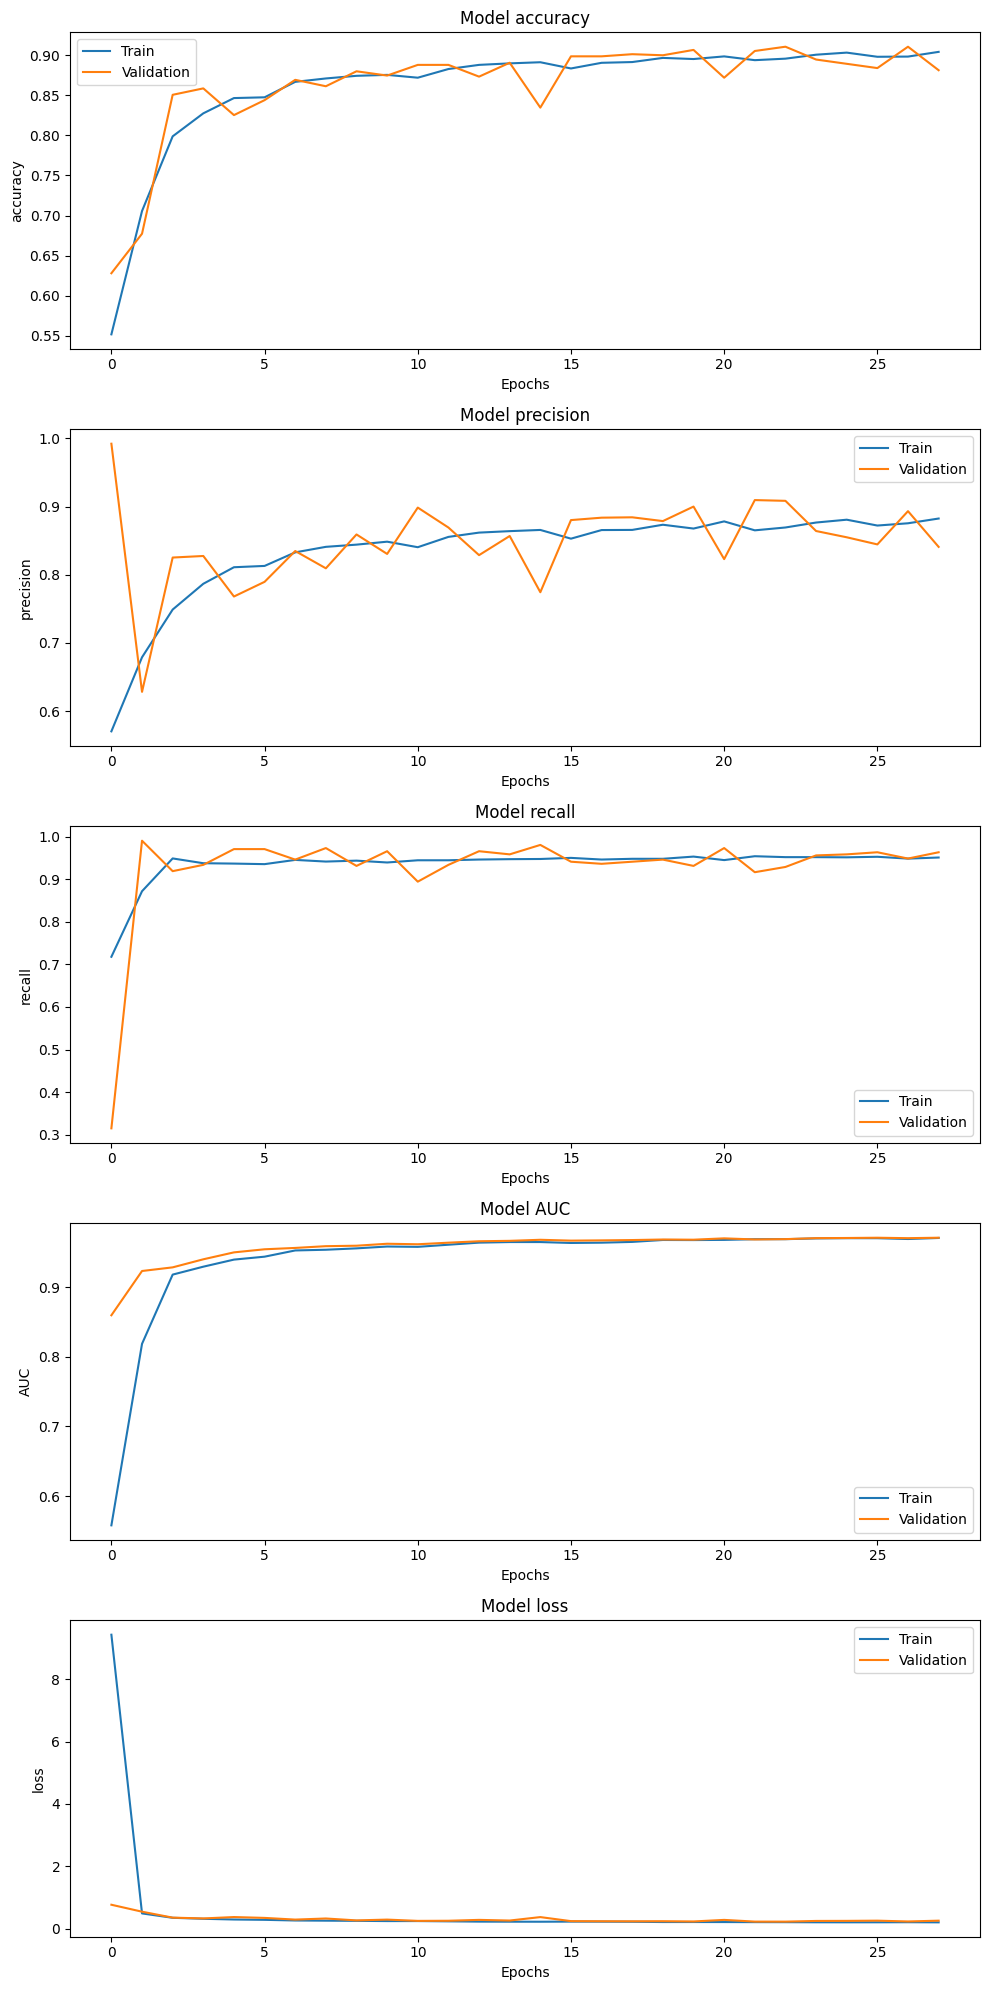

In [41]:
# Evaluate and display results
results = model_fcnn.evaluate(test_X_rgb, test_Y) # Evaluate the model on test data
results = dict(zip(model_fcnn.metrics_names,results))

print(results)
plot_score(history_fcnn) # Visualise scores

In [42]:
'''
import tensorflow as tf

def Cust_Cnn_model1():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model
    '''


"\nimport tensorflow as tf\n\ndef Cust_Cnn_model1():\n    model = tf.keras.Sequential([\n        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),\n        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),\n\n        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),\n        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),\n\n        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),\n        tf.keras.layers.BatchNormalization(),\n        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),\n        tf.keras.layers.Dropout(0.4),\n\n        tf.keras.layers.Flatten(),\n        tf.keras.layers.Dense(256, activation='relu'),\n        tf.keras.layers.BatchNormalization(),\n        tf.keras.layers.Dropout(0.5),\n\n        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification\n    ])\n    return model\n    "

In [43]:
def Cust_Cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding = 'valid', activation = 'relu', input_shape=(64, 64, 3)), #  convolutional layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)), # flatten output of conv
        
        tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding = 'valid', activation = 'relu'), #  convolutional layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)), # flatten output of conv
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'valid'),
        tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'valid'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(), # flatten output of conv
        tf.keras.layers.Dense(512, activation = "relu"), # hidden layer
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation = "relu"), #  output layer
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation = "sigmoid")])
    
    return model

In [44]:

# Instantiate the model
model_cnn = Cust_Cnn_model()


c:\Users\samya\PyCharmProject\Pneumonia-Detection\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [45]:

# Print model summary
model_cnn.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,638,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,810,273 (6.91 MB)

 Trainable params: 1,808,737 (6.90 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [46]:

# Compile the model
model_cnn.compile(optimizer='adam',loss='binary_crossentropy', metrics=METRICS)


In [59]:
# Fit model
history_cnn = model_cnn.fit(train_X_rgb, 
                      train_Y,  
                      epochs=50, 
                      validation_split = 0.15, 
                      batch_size=128,
                      class_weight=classweight,
                      callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler_cb],
                      verbose=1) # Fit the model


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - AUC: 0.9901 - accuracy: 0.9555 - loss: 0.1095 - precision: 0.9432 - recall: 0.9770
Epoch 1: val_loss did not improve from 0.12801
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 428ms/step - AUC: 0.9901 - accuracy: 0.9555 - loss: 0.1094 - precision: 0.9432 - recall: 0.9770 - val_AUC: 0.5043 - val_accuracy: 0.5453 - val_loss: 3.6297 - val_precision: 0.5435 - val_recall: 1.0000 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.008912509381337455.
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - AUC: 0.9925 - accuracy: 0.9622 - loss: 0.0937 - precision: 0.9500 - recall: 0.9824
Epoch 2: val_loss did not improve from 0.12801
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 427ms/step - AUC: 0.9925 - accuracy: 0.9622 - loss: 0.0938 - precision: 0.9500 - recall: 0.9823 - val_AUC: 0.5232 - val_accuracy: 0.5360 - val_loss: 2.4028 - val_precision: 0.5399 - val_recall: 0.9655 - 

34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 417ms/step - AUC: 0.9922 - accuracy: 0.9543 - loss: 0.1000 - precision: 0.9397 - recall: 0.9780 - val_AUC: 0.9958 - val_accuracy: 0.9733 - val_loss: 0.0704 - val_precision: 0.9849 - val_recall: 0.9655 - learning_rate: 0.0071

Epoch 5: LearningRateScheduler setting learning rate to 0.006309573444801933.
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - AUC: 0.9951 - accuracy: 0.9685 - loss: 0.0749 - precision: 0.9570 - recall: 0.9870
Epoch 5: val_loss did not improve from 0.07036
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 440ms/step - AUC: 0.9950 - accuracy: 0.9685 - loss: 0.0750 - precision: 0.9570 - recall: 0.9870 - val_AUC: 0.8088 - val_accuracy: 0.6680 - val_loss: 0.9613 - val_precision: 0.6351 - val_recall: 0.9089 - learning_rate: 0.0063

Epoch 6: LearningRateScheduler setting learning rate to 0.005623413251903491.
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - AUC: 0.9945 - accuracy: 0.9666 - loss: 0.0780 - precision: 0.9613 - recall: 0.9786
Epoch 6: 

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - AUC: 0.9930 - accuracy: 0.9736 - loss: 0.0826 - precision: 0.9829 - recall: 0.9673
Test Results: {'loss': 0.07745510339736938, 'compile_metrics': 0.9739999771118164}


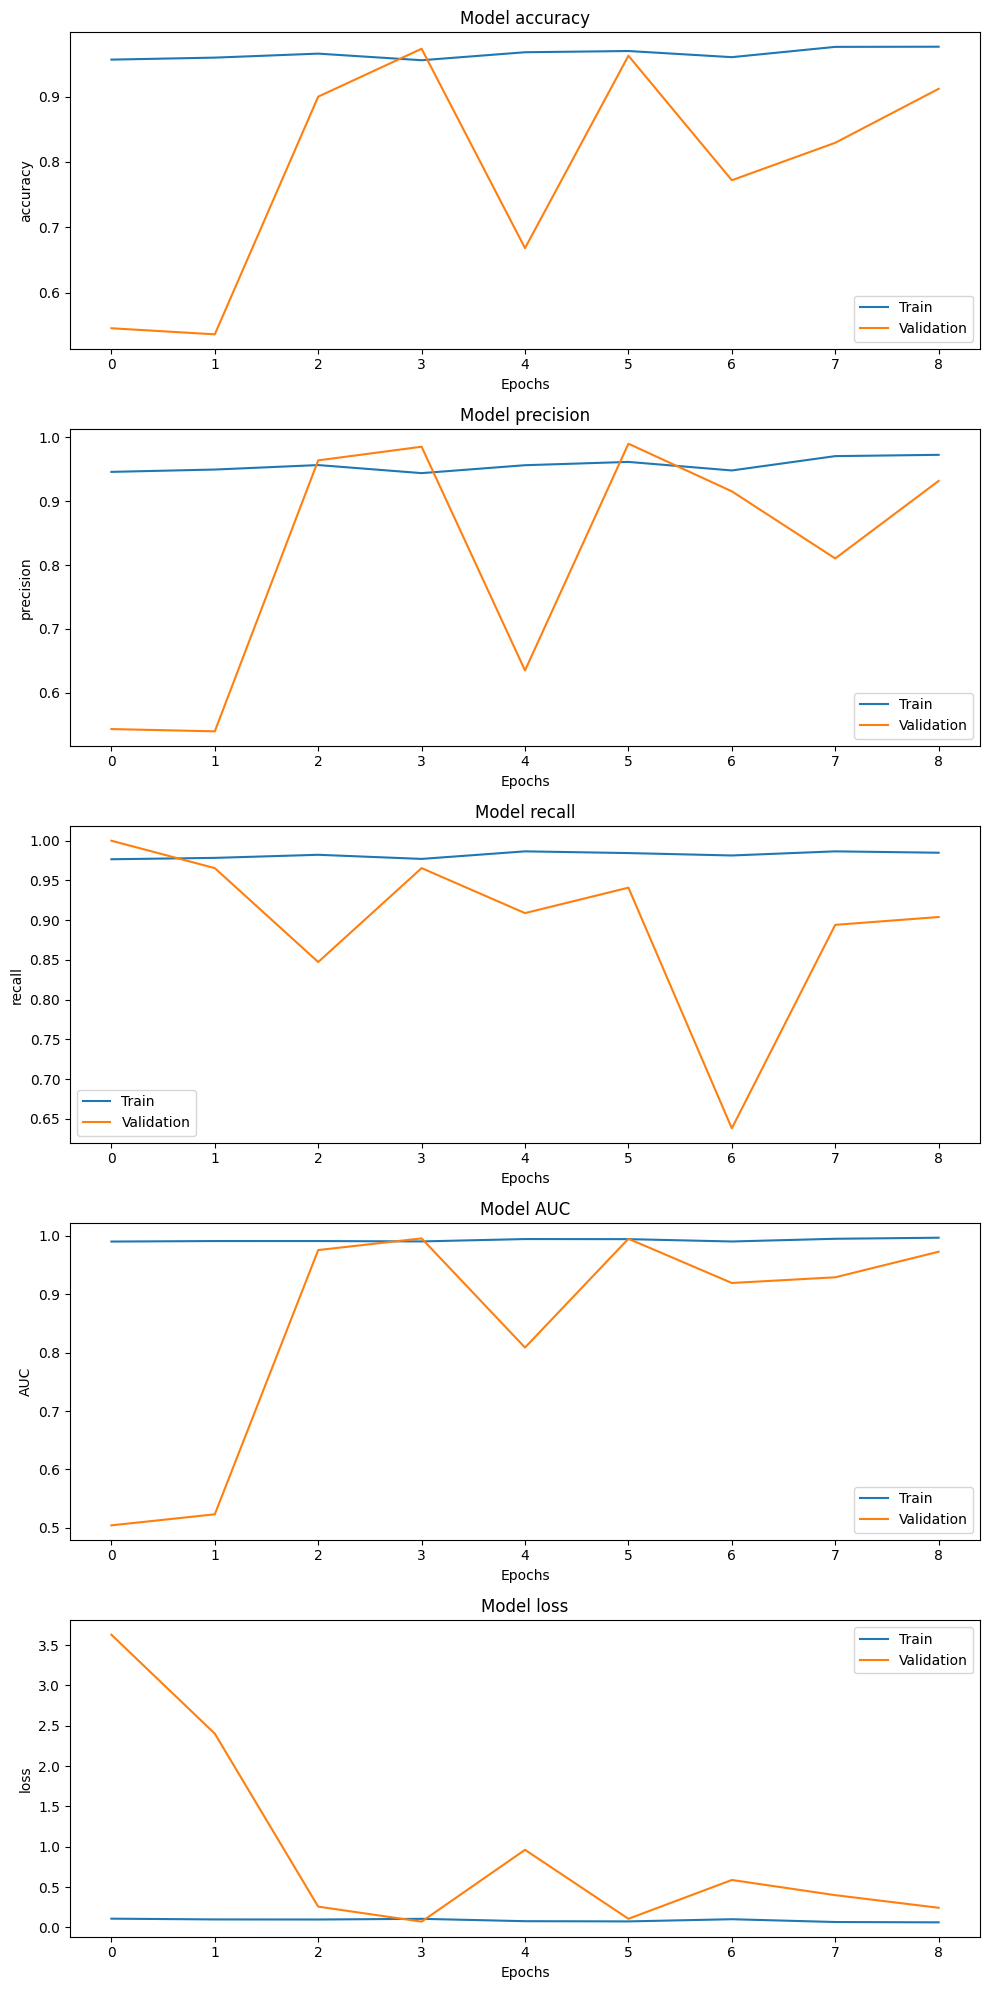

In [60]:
# Evaluate the trained model on test data
results = model_cnn.evaluate(test_X_rgb, test_Y, verbose=1)

# Convert results to a dictionary for readability
results_dict = dict(zip(model_cnn.metrics_names, results))
print("Test Results:", results_dict)

# Visualize training history
plot_score(history_cnn)


In [49]:
model = Cust_Cnn_model()

In [50]:
def build_mn_model():
    model= tf.keras.Sequential([
        tf.keras.applications.MobileNetV2(include_top = False, weights="imagenet", input_shape=(64, 64, 3)),
        tf.keras.layers.GlobalAveragePooling2D(),
        Dense(1, activation = 'sigmoid')
    ])
    model.layers[0].trainable = False
    return model


In [51]:
# Build and compile mobile net model
model_mn = build_mn_model()
model_mn.summary()
model_mn.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

C:\Users\samya\AppData\Local\Temp\ipykernel_11788\1279185705.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  tf.keras.applications.MobileNetV2(include_top = False, weights="imagenet", input_shape=(64, 64, 3)),


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [52]:
history_mn = model_mn.fit(train_X_rgb, 
                          train_Y,  
                          epochs = 100, 
                          validation_split = 0.15, 
                          class_weight = classweight,
                          batch_size = 128,
                          callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler_cb]
                          )


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - AUC: 0.9540 - accuracy: 0.7666 - loss: 0.4396 - precision: 0.8826 - recall: 0.9011
Epoch 1: val_loss did not improve from 0.18762
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 455ms/step - AUC: 0.9540 - accuracy: 0.7689 - loss: 0.4355 - precision: 0.8824 - recall: 0.9016 - val_AUC: 0.9761 - val_accuracy: 0.9267 - val_loss: 0.1933 - val_precision: 0.9229 - val_recall: 0.9433 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.008912509381337455.
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - AUC: 0.9847 - accuracy: 0.9407 - loss: 0.1404 - precision: 0.9272 - recall: 0.9671
Epoch 2: val_loss did not improve from 0.18762
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 563ms/step - AUC: 0.9847 - accuracy: 0.9407 - loss: 0.1405 - precision: 0.9270 - recall: 0.9672 - val_AUC: 0.9799 - val_accuracy: 0.9293 - val_loss: 0.1900 - val_precision: 0.9057 - val_recall: 0.9704 

34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 419ms/step - AUC: 0.9924 - accuracy: 0.9568 - loss: 0.1054 - precision: 0.9468 - recall: 0.9769 - val_AUC: 0.9863 - val_accuracy: 0.9347 - val_loss: 0.1577 - val_precision: 0.9142 - val_recall: 0.9704 - learning_rate: 0.0079

Epoch 4: LearningRateScheduler setting learning rate to 0.0070794578438413795.
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - AUC: 0.9940 - accuracy: 0.9602 - loss: 0.0944 - precision: 0.9437 - recall: 0.9836
Epoch 4: val_loss did not improve from 0.15768
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 515ms/step - AUC: 0.9940 - accuracy: 0.9603 - loss: 0.0944 - precision: 0.9438 - recall: 0.9836 - val_AUC: 0.9877 - val_accuracy: 0.9387 - val_loss: 0.1586 - val_precision: 0.9167 - val_recall: 0.9754 - learning_rate: 0.0071

Epoch 5: LearningRateScheduler setting learning rate to 0.006309573444801933.
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - AUC: 0.9953 - accuracy: 0.9669 - loss: 0.0861 - precision: 0.9510 - recall: 0.9896
Epoch 

34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 548ms/step - AUC: 0.9953 - accuracy: 0.9669 - loss: 0.0860 - precision: 0.9511 - recall: 0.9896 - val_AUC: 0.9888 - val_accuracy: 0.9440 - val_loss: 0.1434 - val_precision: 0.9292 - val_recall: 0.9704 - learning_rate: 0.0063

Epoch 6: LearningRateScheduler setting learning rate to 0.005623413251903491.
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - AUC: 0.9965 - accuracy: 0.9737 - loss: 0.0751 - precision: 0.9610 - recall: 0.9924
Epoch 6: val_loss improved from 0.14335 to 0.13932, saving model to xray_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 443ms/step - AUC: 0.9965 - accuracy: 0.9737 - loss: 0.0751 - precision: 0.9610 - recall: 0.9924 - val_AUC: 0.9893 - val_accuracy: 0.9413 - val_loss: 0.1393 - val_precision: 0.9229 - val_recall: 0.9729 - learning_rate: 0.0056

Epoch 7: LearningRateScheduler setting learning rate to 0.005011872336272724.
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - AUC: 0.9967 - accuracy: 0.9788 - loss: 0.0695 - precision: 0.9687 - recall: 0.9927
Epoch 7: val_loss did not improve from 0.13932
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 380ms/step - AUC: 0.9967 - accuracy: 0.9787 - loss: 0.0696 - precision: 0.9686 - recall: 0.9927 - val_AUC: 0.9888 - val_accuracy: 0.9413 - val_loss: 0.1547 - val_precision: 0.9209 - val_recall: 0.9754 - learning_rate: 0.0050

Epoch 8: LearningRateScheduler setting learning rate to 0.004466835921509631.
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - AUC: 0.9984 - accuracy: 0.9754 - loss: 0.0610 - precision: 0.9587 - recall: 0.9963
Epoch 8

34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 444ms/step - AUC: 0.9970 - accuracy: 0.9784 - loss: 0.0635 - precision: 0.9646 - recall: 0.9959 - val_AUC: 0.9904 - val_accuracy: 0.9453 - val_loss: 0.1300 - val_precision: 0.9314 - val_recall: 0.9704 - learning_rate: 0.0035

Epoch 11: LearningRateScheduler setting learning rate to 0.0031622776601683794.
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - AUC: 0.9967 - accuracy: 0.9812 - loss: 0.0612 - precision: 0.9705 - recall: 0.9955
Epoch 11: val_loss did not improve from 0.12999
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 415ms/step - AUC: 0.9967 - accuracy: 0.9813 - loss: 0.0610 - precision: 0.9706 - recall: 0.9954 - val_AUC: 0.9900 - val_accuracy: 0.9467 - val_loss: 0.1386 - val_precision: 0.9296 - val_recall: 0.9754 - learning_rate: 0.0032

Epoch 12: LearningRateScheduler setting learning rate to 0.002818382931264454.
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - AUC: 0.9988 - accuracy: 0.9826 - loss: 0.0518 - precision: 0.9741 - recall: 0.9949
E

34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 418ms/step - AUC: 0.9980 - accuracy: 0.9843 - loss: 0.0558 - precision: 0.9765 - recall: 0.9951 - val_AUC: 0.9904 - val_accuracy: 0.9467 - val_loss: 0.1298 - val_precision: 0.9336 - val_recall: 0.9704 - learning_rate: 0.0025

Epoch 14: LearningRateScheduler setting learning rate to 0.0022387211385683395.
Epoch 14/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - AUC: 0.9984 - accuracy: 0.9857 - loss: 0.0490 - precision: 0.9776 - recall: 0.9967
Epoch 14: val_loss did not improve from 0.12978
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 398ms/step - AUC: 0.9984 - accuracy: 0.9857 - loss: 0.0490 - precision: 0.9777 - recall: 0.9967 - val_AUC: 0.9897 - val_accuracy: 0.9427 - val_loss: 0.1458 - val_precision: 0.9211 - val_recall: 0.9778 - learning_rate: 0.0022

Epoch 15: LearningRateScheduler setting learning rate to 0.0019952623149688802.
Epoch 15/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - AUC: 0.9974 - accuracy: 0.9831 - loss: 0.0523 - precision: 0.9721 - recall: 0.9976


34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 412ms/step - AUC: 0.9993 - accuracy: 0.9892 - loss: 0.0434 - precision: 0.9825 - recall: 0.9977 - val_AUC: 0.9905 - val_accuracy: 0.9453 - val_loss: 0.1280 - val_precision: 0.9314 - val_recall: 0.9704 - learning_rate: 0.0018

Epoch 17: LearningRateScheduler setting learning rate to 0.0015848931924611134.
Epoch 17/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - AUC: 0.9986 - accuracy: 0.9887 - loss: 0.0464 - precision: 0.9816 - recall: 0.9977
Epoch 17: val_loss did not improve from 0.12801
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 439ms/step - AUC: 0.9986 - accuracy: 0.9886 - loss: 0.0464 - precision: 0.9816 - recall: 0.9977 - val_AUC: 0.9902 - val_accuracy: 0.9440 - val_loss: 0.1388 - val_precision: 0.9252 - val_recall: 0.9754 - learning_rate: 0.0016

Epoch 18: LearningRateScheduler setting learning rate to 0.0014125375446227546.
Epoch 18/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - AUC: 0.9988 - accuracy: 0.9877 - loss: 0.0465 - precision: 0.9785 - recall: 0.9986


94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - AUC: 0.9871 - accuracy: 0.9433 - loss: 0.1501 - precision: 0.9375 - recall: 0.9571
{'loss': 0.144526869058609, 'compile_metrics': 0.9473333358764648}


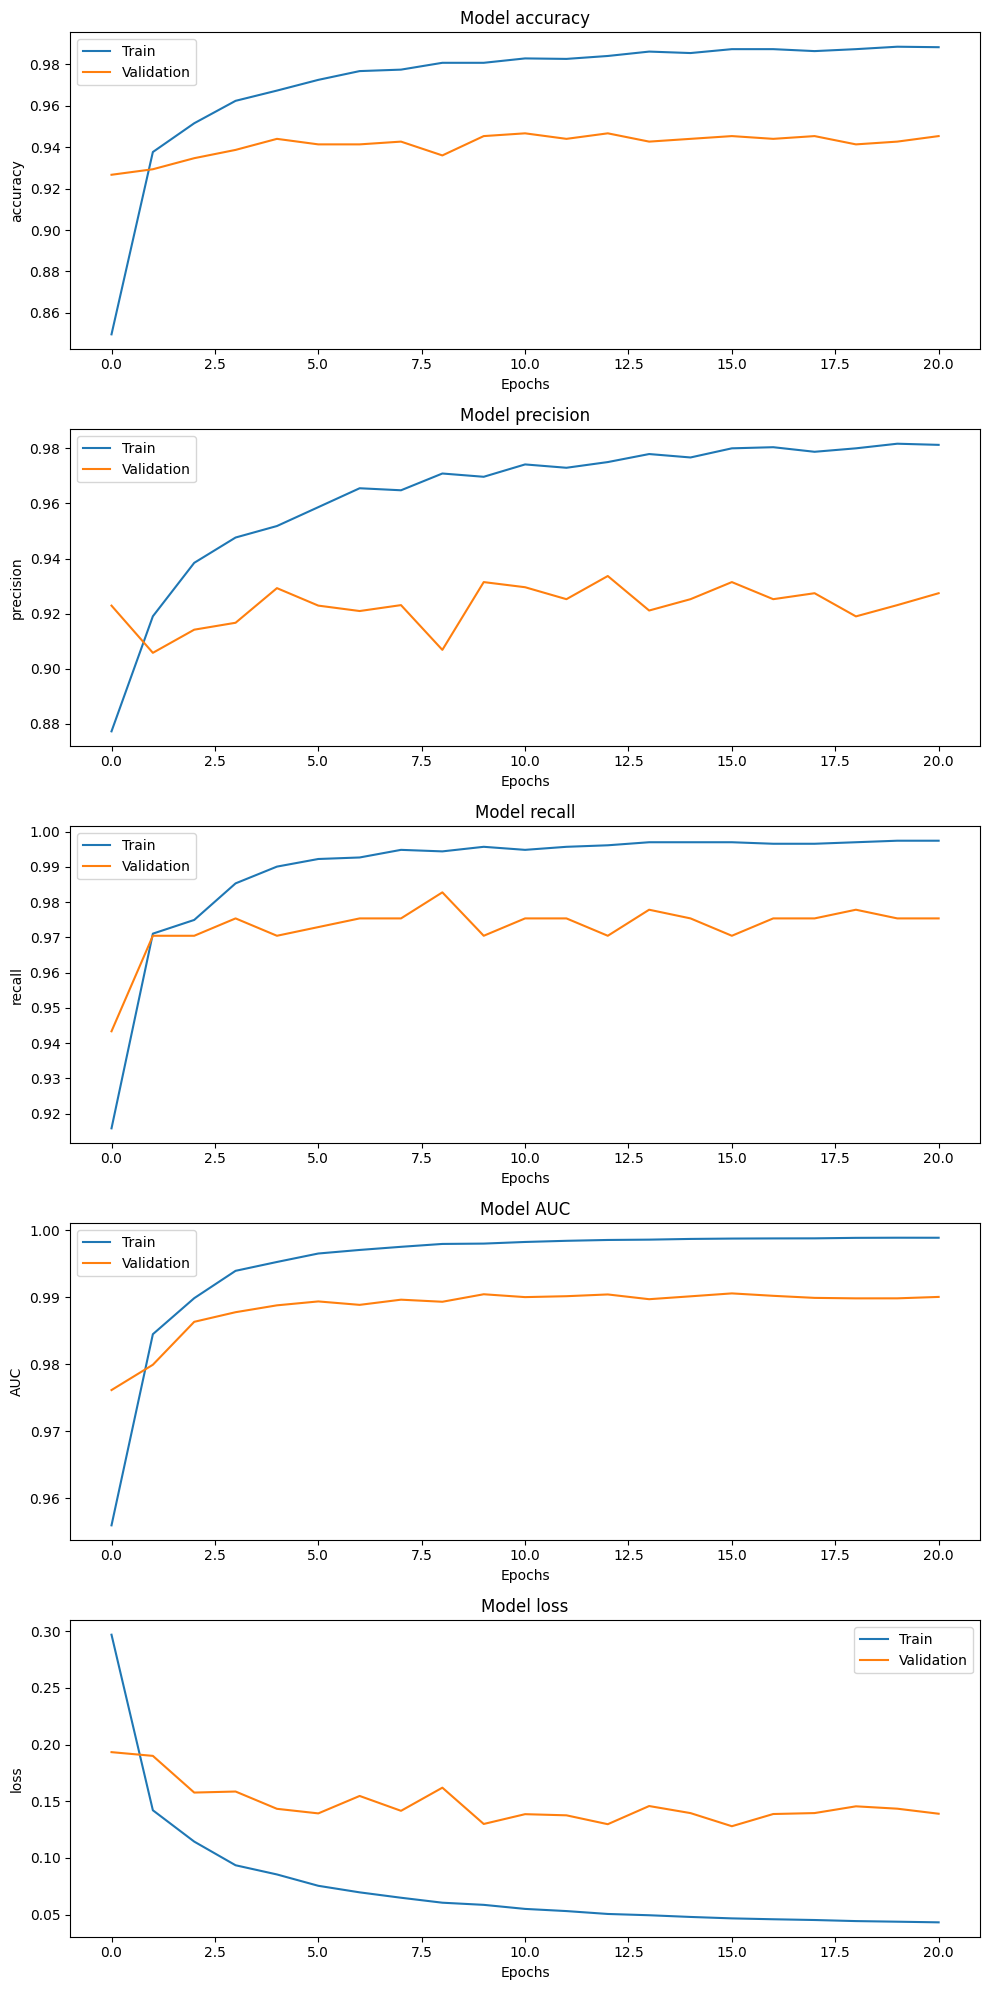

In [53]:
# Show results and print graphs
results = model_mn.evaluate(test_X_rgb, test_Y)
results = dict(zip(model_mn.metrics_names,results))

print(results)
plot_score(history_mn) # Visualise scores

A/B Testing 


In [54]:
train_dcms = [pydicom.dcmread(path) for path in tqdm(train_img_path)]
trainMetaDicts, _ = zip(*[parseMetadata(dcm) for dcm in tqdm(train_dcms)])
train_df = pd.DataFrame.from_dict(data=trainMetaDicts)
train_Y = createY(train_df)


100%|██████████| 26684/26684 [00:31<00:00, 848.91it/s]


In [55]:
import numpy as np
import random
import pydicom
import cv2
import tensorflow as tf

# Select a random index beyond the first 5000
random_index = random.choice(range(5000, len(train_img_path)))
#random_index = random.choice(range(0, 5000))

# Get the image path and true label
image_path = train_img_path[random_index]
true_label = train_Y[random_index]

# Load and preprocess the DICOM image
def load_and_preprocess_dicom(path):
    dicom = pydicom.dcmread(path)
    img = dicom.pixel_array.astype(np.float32)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    img_rgb = np.stack((img,) * 3, axis=-1)  # Convert grayscale to RGB
    return np.expand_dims(img_rgb, axis=0)  # Add batch dimension

# Prepare image
input_image = load_and_preprocess_dicom(image_path)

# Predict using the trained model
prediction = model_cnn.predict(input_image)[0][0]
predicted_label = int(prediction >= 0.5)

# Output results
print(f"Random image path: {image_path}")
print(f"True label: {true_label}")
print(f"Predicted probability: {prediction:.4f}")
print(f"Predicted label: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
Random image path: C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_images\ea696000-e0e3-495e-82e1-e0b5ea273cb7.dcm
True label: 1
Predicted probability: 0.3679
Predicted label: 0


In [56]:
import numpy as np
import random
import pydicom
import cv2
import tensorflow as tf

# Select a random index beyond the first 5000
random_index = random.choice(range(5000, len(train_img_path)))
#random_index = random.choice(range(0, 5000))

# Get the image path and true label
image_path = train_img_path[random_index]
true_label = train_Y[random_index]

# Load and preprocess the DICOM image
def load_and_preprocess_dicom(path):
    dicom = pydicom.dcmread(path)
    img = dicom.pixel_array.astype(np.float32)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    img_rgb = np.stack((img,) * 3, axis=-1)  # Convert grayscale to RGB
    return np.expand_dims(img_rgb, axis=0)  # Add batch dimension

# Prepare image
input_image = load_and_preprocess_dicom(image_path)

# Predict using the trained model
prediction = model_fcnn.predict(input_image)[0][0]
predicted_label = int(prediction >= 0.5)

# Output results
print(f"Random image path: {image_path}")
print(f"True label: {true_label}")
print(f"Predicted probability: {prediction:.4f}")
print(f"Predicted label: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Random image path: C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_images\85eebfe1-8819-408e-a5a0-6df1d4165e9a.dcm
True label: 0
Predicted probability: 0.0788
Predicted label: 0
